<a href="https://colab.research.google.com/github/GenaroHacker/creating_chord_collection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#@title Set Up
!git clone https://github.com/GenaroHacker/write_imports.git
from write_imports.write_imports import write_imports

!git clone https://github.com/GenaroHacker/creating_chord_collection.git


from creating_chord_collection.collection.resources.scales import scales
from creating_chord_collection.collection.resources.transposable_figures import transposable_figures



In [2]:



# Delete this line to see the new imports
%%capture



#@title Import Statements
#Modules: ['creating_chord_collection', 'write_imports']




from creating_chord_collection.builder.director import Director

from creating_chord_collection.builder.builders import AbstractBuilder
from creating_chord_collection.builder.builders import ShortBuilder
from creating_chord_collection.builder.builders import LongBuilder

from creating_chord_collection.collection.chord import GuitarChord

from creating_chord_collection.collection.collection import ChordCollection



from write_imports.write_imports import write_imports

from write_imports.LearningPython.BasicExamples.intro_functions import print_hello_world





print(write_imports([]))






In [6]:
# @title Collection



# Example usage
chord_collection = ChordCollection()
chord_collection.load('/content/creating_chord_collection/collection/resources/chord_collection.db')

chord = chord_collection.chords[6]
print(chord)
chord.transpose(1)
print(chord)
chord_collection.save('new_chord_collection.db')
print(f"Collection Size: {len(chord_collection.chords)}")
chord_collection.extend_barre_chords()
print(f"Collection Size: {len(chord_collection.chords)}")

whitelist = {
     "root": ["C", "F", "G"],
     "chord_type": ["", "m", "dim"],
     "open": [False],
     "starting_fret": [1, 2, 5, 9],
     "include_string": [1, 2],
     "inversion": [1, 2, 3, None],
     "scale": [("C", scales["ionian"])]
 }

filtered_chords = chord_collection.only(whitelist)
print(f"Remaining after whitelist filter: {len(filtered_chords)}")

blacklist = whitelist
filtered_chords = chord_collection.filter_out(blacklist)
print(f"Remaining after blacklist filter: {len(filtered_chords)}")

tonality = chord_collection.get_tonality("B", scales["aeolian"], amplitude=3, rank=2)
print(f"Chords in tonality: {len(tonality)}")


('A', 'm', finger_ascending=[0, 1, 2, 2, 0, None], starting_fret=1)
('A#', 'm', finger_ascending=[1, 2, 3, 3, 1, None], starting_fret=1)
Collection Size: 132
Collection Size: 328
Remaining after whitelist filter: 1
Remaining after blacklist filter: 327
Chords in tonality: 10


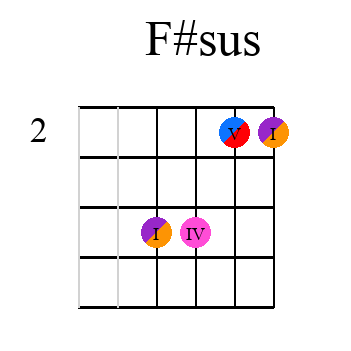

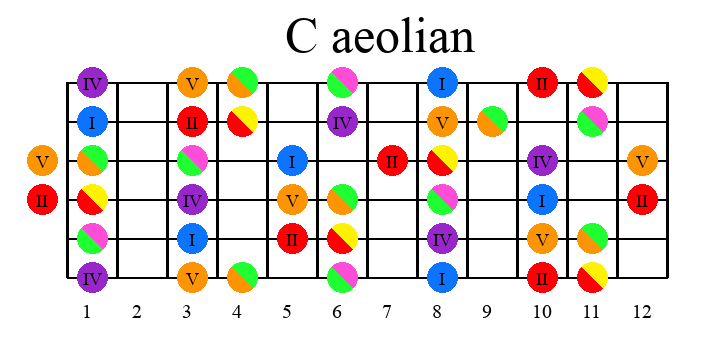

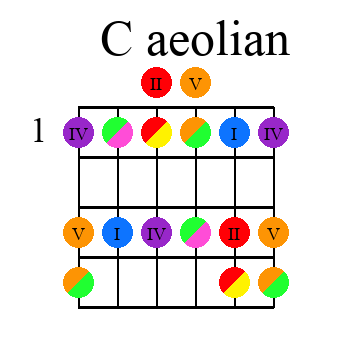

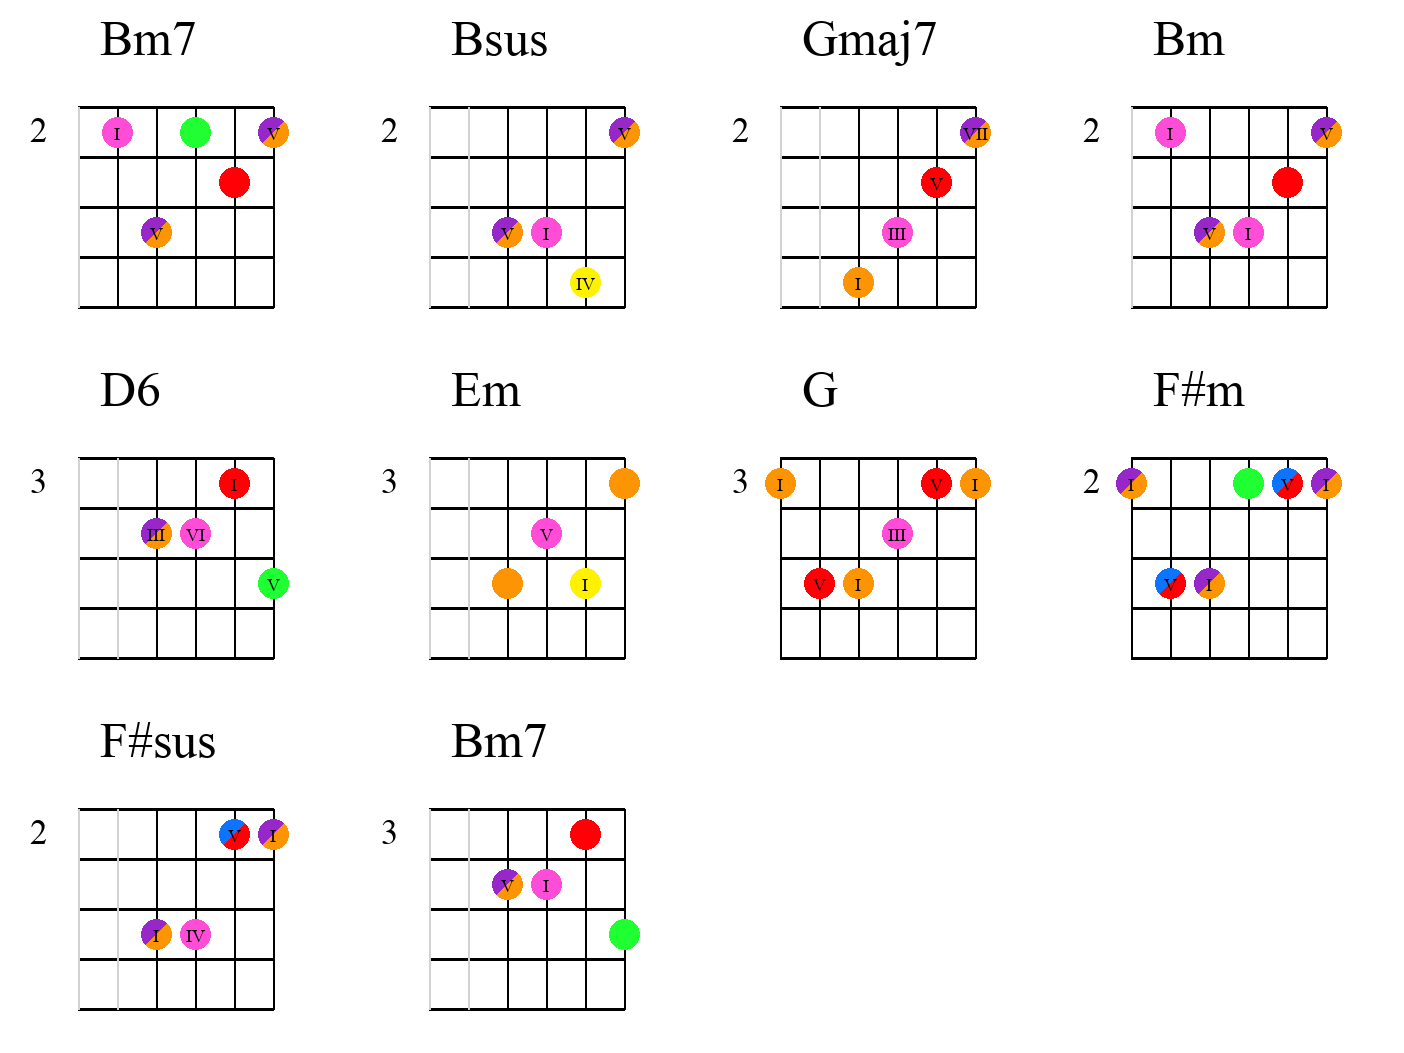

In [7]:
# @title Execution
# Example usage for a chord with LongBuilder
chord = tonality[8]


# Repeat the process with ShortChordBuilder
builder = ShortBuilder()
director = Director(builder)
director.build_chord(chord)
director.display_image()  # Directly display the image

# Define the scale as a list of integers
selected_scale = scales["aeolian"]
root_note = "C"

# Example usage for a scale with LongScaleBuilder
builder = LongBuilder()
director = Director(builder)
director.build_scale(root_note, selected_scale)
director.display_image()  # Directly display the image

# Repeat the process with ShortScaleBuilder
builder = ShortBuilder()
director = Director(builder)
director.build_scale(root_note, selected_scale)
director.display_image()  # Directly display the image

director.build_multiple_chords(tonality, columns=4)
director.display_image()